In [36]:
import numpy as np
import matplotlib.pyplot as plt
from src.cosmolopy import constants

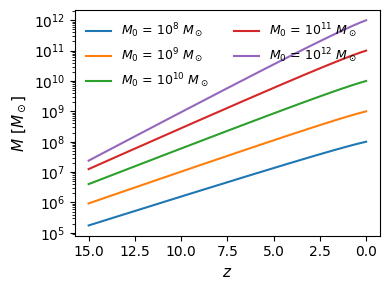

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# your classes
from src.halo_mass_history import HaloMassHistory
from src.halo_mass_function import HaloMassFunction

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', "#0a58b8"]
linestyles = ['-', ':', '-.']

z_grid = np.linspace(0, 15, 501)   

# halo-mass function today 
hmf0 = HaloMassFunction(0)

# Present-day halo masses
final_masses = [1e8, 1e9, 1e10, 1e11, 1e12]#, 1e13]
M_latex      = [r'$10^8$', r'$10^9$', r'$10^{10}$',
                r'$10^{11}$', r'$10^{12}$',
                r'$10^{13}$', r'$10^{14}$']

fig, ax = plt.subplots(figsize=(4, 3))

i = 0
for M0, label in zip(final_masses, M_latex):
    # history object with present-day mass
    history = HaloMassHistory(mass_at_zi=M0, zi=0, halomassfunction=hmf0)
    M_z = history.mass_at_z_from_zi(z_grid)   # descendant mass at each z

    ax.plot(z_grid, M_z, color = colors[i], label=f"$M_0$ = {label} $M_\\odot$")
    i+=1

plt.gca().invert_xaxis()
plt.yscale("log")
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Halo mass $M(z)\,[M_\odot]$')
# ax.set_xlim(0, 25)

plt.xlabel("$z$", fontsize = 11)
plt.ylabel(r'$M \,\, [M_\odot$]', fontsize = 11)
plt.legend(ncol = 2, frameon = False, fontsize = 9)
# plt.grid(which="major", ls="-.", alpha=0.2)
plt.tight_layout()
# plt.show()

plt.savefig('Figures/HaloMassEvo.pdf')


### Below bits not used

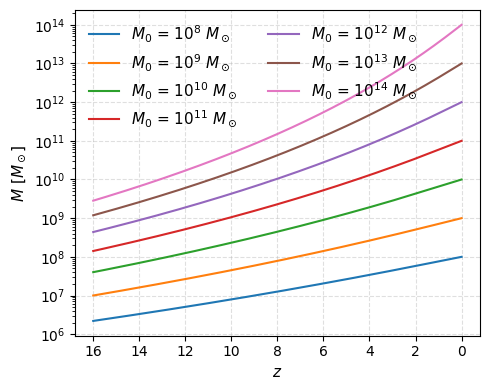

In [ ]:
h = 0.674  
H0 = h * 100 / constants.Mpc_km * constants.yr_s # Hubble constant yr^-1
omega_m0 = 0.315
omega_l0 = 0.685

def H(z):
    return H0 * np.sqrt(omega_m0*(1+z)**3 + omega_l0)

def dMdt(M, z):
    return 46.1 * (M/1e12)**1.1 * (1 + 1.11*z) * np.sqrt(omega_m0*(1+z)**3 + omega_l0)

def dMdz(M, z):
    return -dMdt(M, z)/((1+z)*H(z))

def integrate_mass(M0, z_max=16, steps=2000):
    zs = np.linspace(0, z_max, steps)
    Ms = np.empty_like(zs)
    Ms[0] = M0
    # 4th‐order Runge–Kutta method
    for i in range(steps-1):
        z, dz = zs[i], zs[i+1]-zs[i]
        k1 = dMdz(Ms[i], z)
        k2 = dMdz(Ms[i] + 0.5*k1*dz, z + 0.5*dz)
        k3 = dMdz(Ms[i] + 0.5*k2*dz, z + 0.5*dz)
        k4 = dMdz(Ms[i] + k3*dz, z + dz)
        Ms[i+1] = Ms[i] + (dz/6)*(k1 + 2*k2 + 2*k3 + k4)
    return zs, Ms

final_masses = [1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14]
M_latex = [r'$10^8$', r'$10^9$', r'$10^{10}$', r'$10^{11}$', r'$10^{12}$', r'$10^{13}$', r'$10^{14}$']
plt.figure(figsize=(5,4))
for i, M0 in enumerate(final_masses):
    zs, Ms = integrate_mass(M0)
    plt.plot(zs, Ms, label=f"$M_0$ = {M_latex[i]} $M_\\odot$")
plt.gca().invert_xaxis()
plt.yscale("log")
plt.xlabel("$z$", fontsize = 11)
plt.ylabel(r'$M \,\, [M_\odot$]', fontsize = 11)
plt.legend(ncol = 2, frameon = False, fontsize = 11)
plt.grid(which="major", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


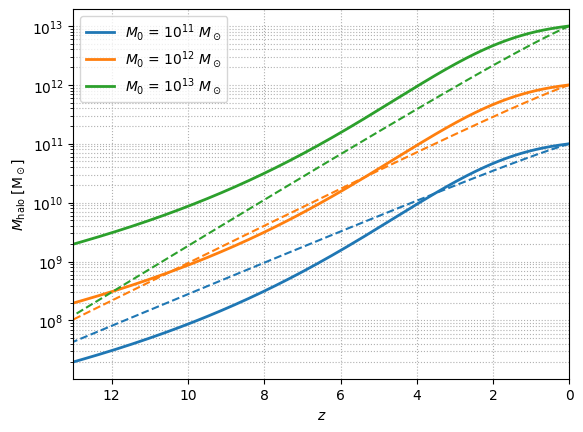

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18
from diffmah.diffmah_kernels import DEFAULT_MAH_PARAMS, mah_singlehalo

from src.halo_mass_history import HaloMassHistory
from src.halo_mass_function import HaloMassFunction

hmf0 = HaloMassFunction(0)


# Redshift ➜ cosmic-time grid 
z_grid = np.linspace(0, 13, 400)      
t_grid = Planck18.age(z_grid).value  # Gyr
lgt0    = np.log10(Planck18.age(0).value) 

final_masses = [1e11, 1e12, 1e13]      # Msun today
M_latex      = [r'$10^{11}$', r'$10^{12}$', r'$10^{13}$', r'$10^{14}$']

fig, ax = plt.subplots()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', "#0a58b8"]

i = 0
for M0, lbl in zip(final_masses, M_latex):
    pars = DEFAULT_MAH_PARAMS._replace(logm0=np.log10(M0))
    _, log10_m = mah_singlehalo(pars, t_grid, lgt0)
    ax.plot(z_grid, 10**log10_m, lw=2, color = colors[i], label=f"$M_0$ = {lbl} $M_\\odot$")   # linear mass on y
    i+=1

i = 0
for M0, label in zip(final_masses, M_latex):
    # history object with present-day mass
    history = HaloMassHistory(mass_at_zi=M0, zi=0, halomassfunction=hmf0)
    M_z = history.mass_at_z_from_zi(z_grid)   # descendant mass at each z

    ax.plot(z_grid, M_z, color = colors[i], linestyle = '--')

    i+=1

ax.set_yscale('log')
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$M_{\rm halo}\;[\mathrm{M_\odot}]$")  
ax.set_xlim(z_grid.max(), z_grid.min())    
# or: ax.invert_xaxis()

ax.grid(True, which="both", ls=":")
ax.legend()
plt.show()
